In [128]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

In [129]:
df_ks = pd.read_csv("ks-projects-201801.csv")

In [130]:
display(df_ks)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,canceled,1,US,25.0,25.0,50000.00
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,failed,5,US,155.0,155.0,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,failed,1,US,20.0,20.0,15000.00
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,failed,6,US,200.0,200.0,15000.00


In [131]:
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [132]:
#欠損値の確認
df_ks.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [133]:
#stateのsuccessfulを1, failedを0とする
df_ks.loc[df_ks["state"] == "successful", "state"] = 1
df_ks.loc[df_ks["state"] == "failed", "state"] = 0

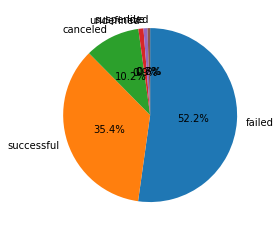

In [134]:
#円グラフを作成し、successfulとfiledが占める割合が88%程度であることから、stateがsuccessfulとfailedのデータからモデルを作成しても良い予測ができると考える
label = ['failed', 'successful', 'canceled', 'undefined', 'live', 'suspended']
 
plt.pie(df_ks['state'].value_counts(),
       labels=label, counterclock=False, startangle=90,
       autopct='%1.1f%%', pctdistance=0.5)
 
plt.show()

In [135]:
#stateのsuccessfulとfailedだけを抽出する
df_ks = df_ks[(df_ks["state"] == 1) | (df_ks["state"] == 0)]
df_ks["state"].value_counts()

0    197719
1    133956
Name: state, dtype: int64

In [136]:
df_ks["main_category"].value_counts()

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

In [137]:
#categoryは細かく分かれすぎているため、類似の情報を持つと考えられるmain_categoryのみをダミー変数にしておく
df_ks["category"].value_counts()

Product Design     18680
Documentary        14523
Music              12633
Tabletop Games     11744
Shorts             11394
                   ...  
Residencies           68
Letterpress           46
Chiptune              33
Literary Spaces       19
Taxidermy             10
Name: category, Length: 159, dtype: int64

In [138]:
#main_categoryをダミー変数に変換
df_ks["main_category"].value_counts()
df_ks.loc[df_ks["main_category"] == "Film & Video", "main_category"] = 1
df_ks.loc[df_ks["main_category"] == "Music", "main_category"] = 2
df_ks.loc[df_ks["main_category"] == "Publishing", "main_category"] = 3
df_ks.loc[df_ks["main_category"] == "Games", "main_category"] = 4
df_ks.loc[df_ks["main_category"] == "Technology", "main_category"] = 5
df_ks.loc[df_ks["main_category"] == "Art", "main_category"] = 6
df_ks.loc[df_ks["main_category"] == "Design", "main_category"] = 7
df_ks.loc[df_ks["main_category"] == "Food", "main_category"] = 8
df_ks.loc[df_ks["main_category"] == "Fashion", "main_category"] = 9
df_ks.loc[df_ks["main_category"] == "Theater", "main_category"] = 10
df_ks.loc[df_ks["main_category"] == "Comics", "main_category"] = 11
df_ks.loc[df_ks["main_category"] == "Photography", "main_category"] = 12
df_ks.loc[df_ks["main_category"] == "Crafts", "main_category"] = 13
df_ks.loc[df_ks["main_category"] == "Journalism", "main_category"] = 14
df_ks.loc[df_ks["main_category"] == "Dance", "main_category"] = 15

In [139]:
df_ks["country"].value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

In [140]:
#countryをダミー変数に変換
country = ['US', 'GB', 'CA', 'AU', 'DE', 'FR', 'NL', 'IT', 'ES', 'SE', 'MX', 'NZ', 'DK', 'IE', 'CH', 'NO', 'BE', 'AT', 'HK', 'SG', 'N,0"', 'LU', 'JP']
for i in range(23):
    df_ks.loc[df_ks["country"] == country[i], "country"] = i
df_ks

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,3,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,1,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,1,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,0,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,1,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,0,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,2,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,0,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,8,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224,0,52375.0,52375.0,50000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,999975836,"Homemade fresh dog food, Cleveland OH",Small Batch,8,USD,2017-04-19,6500.0,2017-03-20 22:08:22,154.0,0,4,0,0.0,154.0,6500.00
378657,999977640,The Tribe,Narrative Film,1,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,0,5,0,155.0,155.0,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,1,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,0,1,0,20.0,20.0,15000.00
378659,999987933,BioDefense Education Kit,Technology,5,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,0,6,0,200.0,200.0,15000.00


In [141]:
#currencyをダミー変数に変換
df_ks["currency"].value_counts()
currency = ["USD", "GBP", "EUR", "CAD", "AUD", "SEK", "MXN", "NZD", "DKK", "CHF", "NOK", "HKD", "SGD", "JPY"]
for i in range(14):
    df_ks.loc[df_ks["currency"] == currency[i], "currency"] = i

In [142]:
df_ks["currency"].value_counts()

0     261511
1      29476
2      14378
3      12375
4       6621
5       1510
6       1411
7       1274
8        929
9        652
10       584
11       477
12       454
13        23
Name: currency, dtype: int64

In [143]:
#クラウドファンディングが終る前に入手できない変数を取り除く
df_ks_drop = df_ks.drop(["pledged", "usd pledged", "usd_pledged_real"], axis = 1)
df_ks_drop

,ID,name,category,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,3,1,2015-10-09,1000.0,2015-08-11 12:12:28,0,0,1,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,1,0,2017-11-01,30000.0,2017-09-02 04:43:57,0,15,0,30000.00
2,1000004038,Where is Hank?,Narrative Film,1,0,2013-02-26,45000.0,2013-01-12 00:20:50,0,3,0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,2,0,2012-04-16,5000.0,2012-03-17 03:24:11,0,1,0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,8,0,2016-04-01,50000.0,2016-02-26 13:38:27,1,224,0,50000.00
...,...,...,...,...,...,...,...,...,...,...,...,...
378654,999975836,"Homemade fresh dog food, Cleveland OH",Small Batch,8,0,2017-04-19,6500.0,2017-03-20 22:08:22,0,4,0,6500.00
378657,999977640,The Tribe,Narrative Film,1,0,2011-07-19,1500.0,2011-06-22 03:35:14,0,5,0,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,1,0,2010-08-16,15000.0,2010-07-01 19:40:30,0,1,0,15000.00
378659,999987933,BioDefense Education Kit,Technology,5,0,2016-02-13,15000.0,2016-01-13 18:13:53,0,6,0,15000.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000233962995E0>,
      dtype=object)

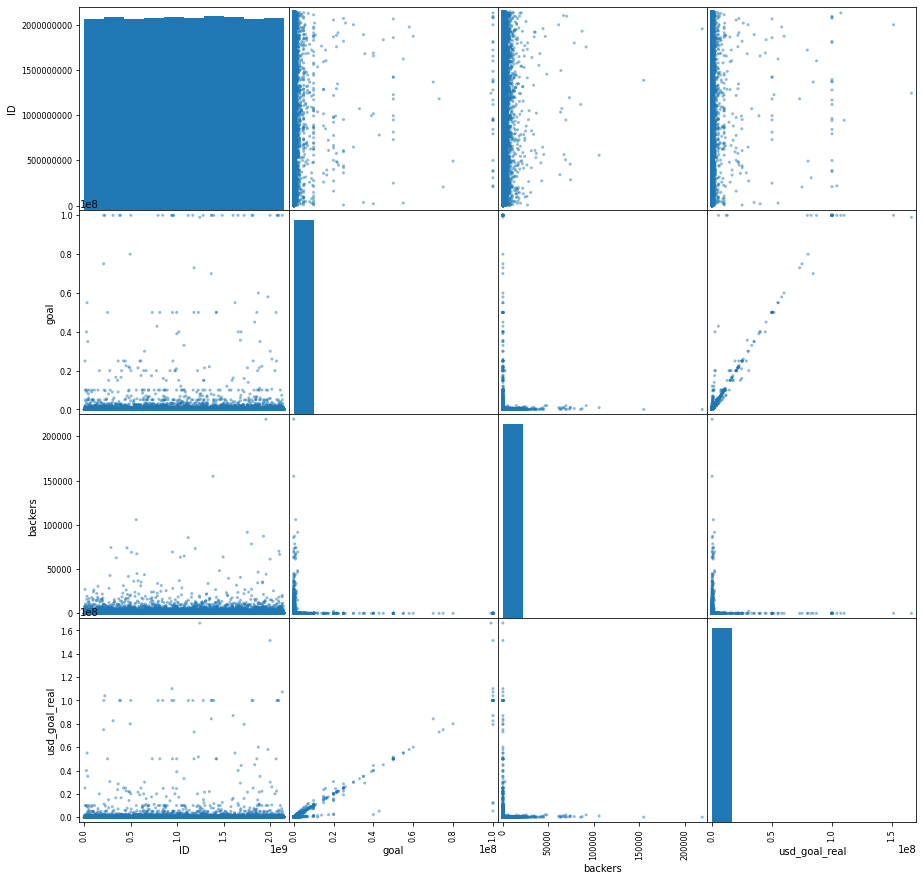

In [144]:
pd.plotting.scatter_matrix(df_ks_drop, figsize = (15, 15))

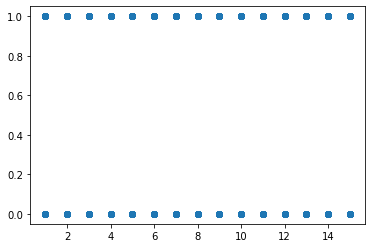

In [145]:
plt.scatter(df_ks_drop["main_category"], df_ks_drop["state"])

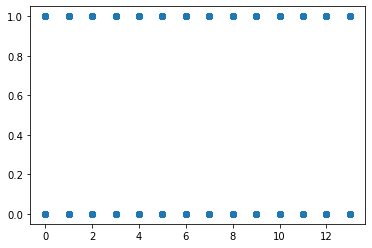

In [146]:
plt.scatter(df_ks_drop["currency"], df_ks_drop["state"])

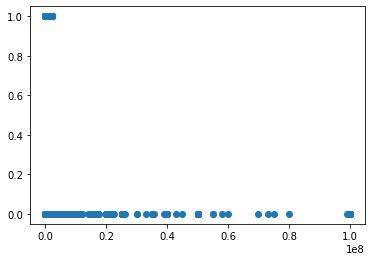

In [147]:
plt.scatter(df_ks_drop["goal"], df_ks_drop["state"])

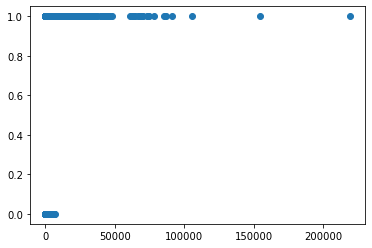

In [148]:
plt.scatter(df_ks_drop["backers"], df_ks_drop["state"])

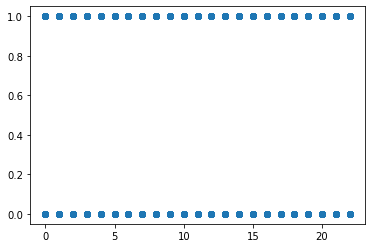

In [149]:
plt.scatter(df_ks_drop["country"], df_ks_drop["state"])

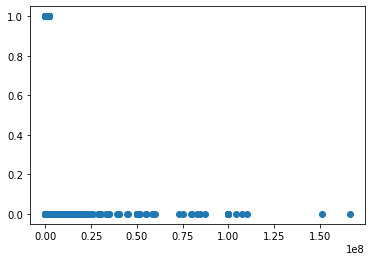

In [150]:
plt.scatter(df_ks_drop["usd_goal_real"], df_ks_drop["state"])

In [153]:
#以上の結果から、説明変数としてgoal, backers, usd_goal_realの3つを用いる
y = df_ks_drop["state"].values
y = y.astype('int')
X = df_ks_drop[["goal", "backers", "usd_goal_real"]].values
clf = SGDClassifier (loss = "log", penalty = "none", max_iter = 10000, fit_intercept = True, random_state = 1234, tol = 1e-3)
clf.fit(X, y)

SGDClassifier(loss='log', max_iter=10000, penalty='none', random_state=1234)

In [154]:
# ラベルを予測
y_pred = clf.predict(X)

accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 90.256%
適合率（Precision） = 96.408%
再現率（Recall） = 86.893%
F1値（F1-score） = 91.403%


In [157]:
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat,
                        index = ["正解 = failed", "正解 = successful"],
                        columns = ["予測 = failed", "予測 = successful"])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,171804,25915
正解 = successful,6402,127554
